# Irony detection using Bi-LSTM

```
En este experimento se probó usar los caracteres como elementos únicos de este modo detectar por ejemplo si usar la combinación de caracteres hola o 'en serio' se pueda distinguir si es una oración irónica o no.

```
Primero  se añadiran las bibliotecas necesarias que se usaran en el código de este notebook.

In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Dropout
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Después se leerán los vectores que se prepocesaron usando el código que dice preprocesamiento.py

In [0]:
def LoadData(archPkl,maxlen,max_features):
  # Load data
  (x_train, y_train),(x_test,y_test)= pickle.load(open(archPkl,'rb'))
  # Reverse sequences
  x_train = [x[::-1] for x in x_train]
  x_test = [x[::-1] for x in x_test]

  # Pad sequences
#   print(x_train[0])
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#   print(x_train[0])
#   x_train=np.array(x_train)
#   x_test=np.array(x_test)
  
  return (x_train, y_train),(x_test,y_test)

Después se realizará la arquitectura de la red neuronal.



In [0]:
def make_model(max_features,batch_size=None):
    tf.keras.backend.clear_session()
    source = Input(shape=(maxlen,), batch_size=batch_size, dtype=tf.float32, name='Input')
    embedding = Embedding(input_dim=max_features, output_dim=128, name='Embedding')(source)
    lstm = Bidirectional(LSTM(200, name = 'LSTM'), name='Bidirectional')(embedding)
    dropout=Dropout(0.5,name="Dropout")(lstm)
    predicted_var = Dense(1, activation='sigmoid', name='Output')(dropout)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_var])
    model.compile(
            optimizer= tf.train.RMSPropOptimizer(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['acc'])
    model_json = model.to_json()
    with open(base+"/Modelo.json","w") as json_file:
      json_file.write(model_json)
    return model

Ahora se entrenará el modelo usando los TPU que se puden usar gracias a Google.

In [0]:
import os
import time

def trainModel(training_model,x_train,y_train,x_test,y_test,weights):
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  # this line is to don't print warnings and info that tf use by default
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
  tf.logging.set_verbosity(tf.logging.ERROR)
  
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
      training_model,
      strategy=tf.contrib.tpu.TPUDistributionStrategy(
          tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

  tpu_model.summary()

  start_time = time.time()

  history = tpu_model.fit(x_train, y_train,
                      epochs=15,
                      batch_size=32 * 8,
                      validation_data=[x_test,y_test])
  tpu_model.save_weights('./tpu_model.h5', overwrite=True)
  !cp ./tpu_model.h5 {weights}
  print("--- %s seconds ---" % (time.time() - start_time))
  return tpu_model

Por último se evalua el módelo y se imprime la gráfica ROC 

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score,f1_score,roc_curve,auc
import numpy as np
import matplotlib.pyplot as plt
import IPython
IPython_default = plt.rcParams.copy()
# # use a gray background
    
# # control face and edge color of histogram
# ax.hist(x, edgecolor='#E6E6E6', color='#EE6666');

def evaluate(x_test,y_test,inferencing_model):
  
  inferencing_model.load_weights('./tpu_model.h5')
  
  y_pred=inferencing_model.predict(x_test,verbose=1,batch_size=32)
  fpr, tpr, thresholds = roc_curve(y_test.astype(float),y_pred )
  y_pred=np.array([int(i) for i in map(np.rint,y_pred)])

  y_test=np.array([int(i) for i in map(np.rint,y_test)])
  # 	for i in range(15):
  # 		print("Test: ",y_test[i])
  # 	# print(y_test)
  print("accuracy ",accuracy_score(y_test,y_pred))
  print("Matriz de confusión ",confusion_matrix(y_test,y_pred))
  print("Recall ",recall_score(y_test,y_pred,average='binary'))
  print("Precision ",precision_score(y_test,y_pred,average='binary'))
  print("F1-score ",f1_score(y_test,y_pred,average='binary'))
  roc_auc=auc(fpr,tpr)
  plt.figure( figsize=(8, 6))
  ax = plt.axes(facecolor='#E6E6E6')
  ax.set_axisbelow(True)

  # draw solid white grid lines
  plt.grid(color='w', linestyle='solid')

#   # hide axis spines
#   for spine in ax.spines.values():
#       spine.set_visible(False)

#   # hide top and right ticks
#   ax.xaxis.tick_bottom()
#   ax.yaxis.tick_left()

#   # lighten ticks and labels
#   ax.tick_params(colors='gray', direction='out')
#   for tick in ax.get_xticklabels():
#       tick.set_color('gray')
#   for tick in ax.get_yticklabels():
#       tick.set_color('gray')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate',fontsize="14")
  plt.ylabel('True Positive Rate',fontsize="14")
  plt.legend(loc="lower right",fontsize='12')
  plt.show()
  return fpr,tpr

In [6]:
base="/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/"
basePesos="/content/drive/My\ Drive/Colab\ Notebooks/DeteccionDeIronia/Experimento3/Pesos/"
baseVect=base+"Vectores/"
ListVect=[baseVect+"vectoresSet{0}_g2.pkl".format(i) for i in range(5)]
ListWeig=[basePesos+"weights{0}_g2.hd5".format(i) for i in range(5)]
# Number of words to consider as features
max_features = 200000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 200
print(baseVect+"\n"+basePesos)
print("\n".join(ListVect))

/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/
/content/drive/My\ Drive/Colab\ Notebooks/DeteccionDeIronia/Experimento3/Pesos/
/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet0_g2.pkl
/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet1_g2.pkl
/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet2_g2.pkl
/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet3_g2.pkl
/content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet4_g2.pkl


Ahora necesitamos aplicarlo para cada uno de nuestros vectores ya preprocesados.

-------------Set /content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet0_g2.pkl-------------
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
Bidirectional (Bidirectional (None, 400)           

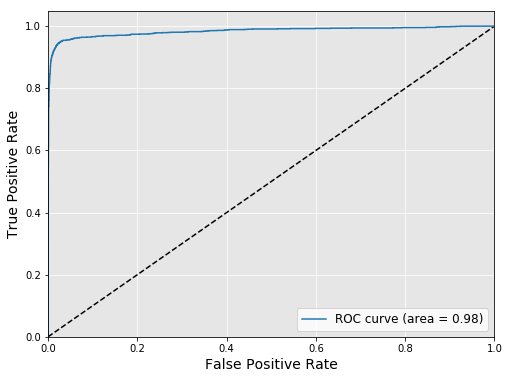

In [7]:
%matplotlib inline
vects=ListVect[0]
weights=ListWeig[0]
print("-------------Set {0}-------------".format(vects))
model=make_model(max_features)
(x_train, y_train),(x_test,y_test)=LoadData(vects,maxlen,max_features)  
tpu_model=trainModel(model,x_train,y_train,x_test,y_test,weights)
fpr,tpr=evaluate(x_test,y_test,model)

-------------Set /content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet1_g2.pkl-------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
Bidirectional (Bidirectional (None, 400)               526400    
_________________________________________________________________
Dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 401       
Total params: 26,126,801
Trainable params: 26,126,801
Non-trainable params: 0
_________________________________________________________________


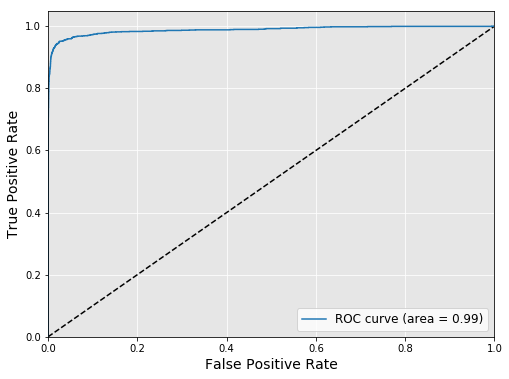

In [8]:
vects=ListVect[1]
weights=ListWeig[1]
print("-------------Set {0}-------------".format(vects))
model=make_model(max_features)
(x_train, y_train),(x_test,y_test)=LoadData(vects,maxlen,max_features)  
tpu_model=trainModel(model,x_train,y_train,x_test,y_test,weights)
fpr,tpr=evaluate(x_test,y_test,model)

-------------Set /content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet2_g2.pkl-------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
Bidirectional (Bidirectional (None, 400)               526400    
_________________________________________________________________
Dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 401       
Total params: 26,126,801
Trainable params: 26,126,801
Non-trainable params: 0
_________________________________________________________________


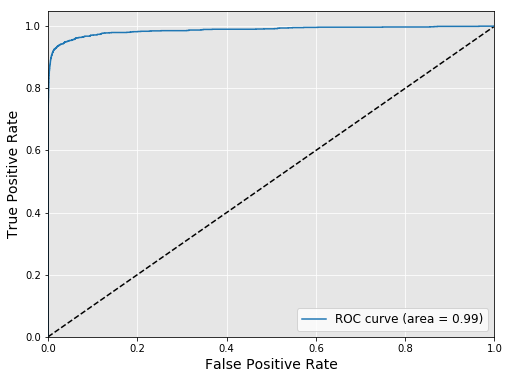

In [9]:
vects=ListVect[2]
weights=ListWeig[2]
print("-------------Set {0}-------------".format(vects))
model=make_model(max_features)
(x_train, y_train),(x_test,y_test)=LoadData(vects,maxlen,max_features)  
tpu_model=trainModel(model,x_train,y_train,x_test,y_test,weights)
fpr,tpr=evaluate(x_test,y_test,model)

-------------Set /content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet3_g2.pkl-------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
Bidirectional (Bidirectional (None, 400)               526400    
_________________________________________________________________
Dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 401       
Total params: 26,126,801
Trainable params: 26,126,801
Non-trainable params: 0
_________________________________________________________________


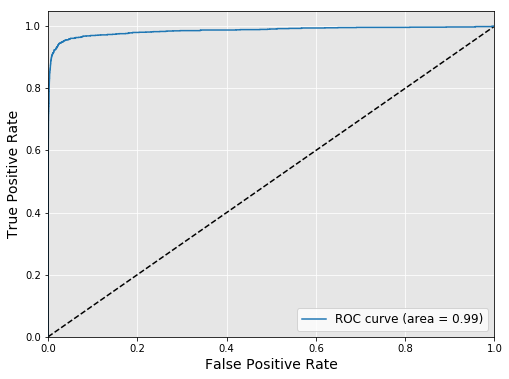

In [10]:
vects=ListVect[3]
weights=ListWeig[3]
print("-------------Set {0}-------------".format(vects))
model=make_model(max_features)
(x_train, y_train),(x_test,y_test)=LoadData(vects,maxlen,max_features)  
tpu_model=trainModel(model,x_train,y_train,x_test,y_test,weights)
fpr,tpr=evaluate(x_test,y_test,model)

-------------Set /content/drive/My Drive/Colab Notebooks/DeteccionDeIronia/Experimento3/Vectores/vectoresSet4_g2.pkl-------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 128)          25600000  
_________________________________________________________________
Bidirectional (Bidirectional (None, 400)               526400    
_________________________________________________________________
Dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 401       
Total params: 26,126,801
Trainable params: 26,126,801
Non-trainable params: 0
_________________________________________________________________


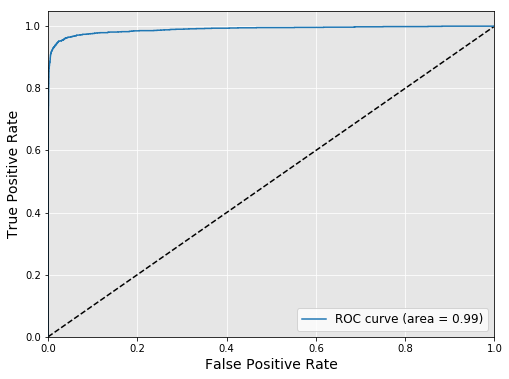

In [11]:
vects=ListVect[4]
weights=ListWeig[4]
print("-------------Set {0}-------------".format(vects))
model=make_model(max_features)
(x_train, y_train),(x_test,y_test)=LoadData(vects,maxlen,max_features)  
tpu_model=trainModel(model,x_train,y_train,x_test,y_test,weights)
fpr,tpr=evaluate(x_test,y_test,model)